[Chris McCormick  BERT Word Embeddings Tutorial](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)
[Visualizing BERT](https://home.ttic.edu/~kgimpel/viz-bert/viz-bert.html#:~:text=This%20page%20hosts%20a%20Jupyter%20Notebook%20for%20creating,a%20file%20with%20sentences%20containing%20a%20given%20word.)

In [17]:
import os.path as path
import time
import hashlib
import random
import numpy as np
from matplotlib import pyplot as plt

from sklearn.manifold import TSNE

import torch
from torch.utils.data import DataLoader

import szx81.core.core_ as co
from szx81.core.core_ import md
from szx81.models.bert_rv.dataset import Data
from szx81.models.bert_rv.pre.model import MODEL

In [10]:
PROJECT_PREPEND = r'_bs256'
PROJECT_DIR = r'C:\Users\stefa\Documents\workspaces\szx81\EURUSD\data_store\tokenizer_piecewise_short;mean_len-15;seg_size-10;idx_step-1;level-4;\BERT_PRE_bert_rv' \
    + PROJECT_PREPEND
PROJECT_NAME_BASE = 'BERT_PRE_bert_rv'

def _():
    project_shell_path = path.join(
        PROJECT_DIR, PROJECT_NAME_BASE + PROJECT_PREPEND + '.pkl')

    project_shell = co.load(project_shell_path, verbose=False)
    data_object = project_shell.data_object
    train_data = data_object.train_data
    val_data = data_object.val_data
    test_data = data_object.test_data
    test_dataset = project_shell.data_object.test_dataset
    tokenizer = project_shell.data_object.tokenizer

    return  project_shell, test_dataset, tokenizer, data_object

PROJECT_SHELL, TEST_DATASET, TOKENIZER, DATA_OBJECT = _()


In [19]:
def _():
    model_path = path.join(
        PROJECT_DIR, PROJECT_NAME_BASE + PROJECT_PREPEND + '_bst_' + '.pt')
    cls = type(PROJECT_SHELL.ms.model_env.model).__base__
    return cls.from_pretrained(model_path)
    
MODEL = _()                           

In [20]:
MASK_IDS = TOKENIZER.convert_tokens_to_ids(TOKENIZER.MASK)
PAD_IDS = TOKENIZER.convert_tokens_to_ids(TOKENIZER.PAD)

def _(hdn_st_idx=-1, sle=slice(0), count=10):
     
    test_dataloader = DataLoader(
                        DATA_OBJECT.test_dataset,
                        batch_size=1, 
                        shuffle=True, 
                        pin_memory=False,
                        drop_last=True,)
    sqc_emb = []
    virtual = []
    direction = []

    while count > 0:
        count -= 1
        batch = next(iter(test_dataloader))
        
        input_ids = batch['input']['input_ids']
        labels = batch['input']['labels']    
        mask_token_index = (input_ids == MASK_IDS).nonzero(as_tuple=True)
        input_ids[mask_token_index] = labels[mask_token_index]
        input_ids[:,:12]
        snd_stc_mask = batch['input']['token_type_ids'].nonzero(as_tuple=True)
        input_ids[snd_stc_mask] = PAD_IDS

        virtual.append(
            TOKENIZER.convert_ids_to_tokens
                                        (batch['admin']['pred_token']).item())
        direction.append(batch['admin']['direction'].item())
        input_ids[0][-2] = MASK_IDS
        with torch.no_grad():
            model_out = MODEL(
                        output_hidden_states=True, 
                        return_dict=True,
                        **batch['input']
                    )
        # sequence embedding : a simple approach is to average the second to last hidden layer of each token
        hidden_states = model_out.hidden_states
        sqc_emb.append(torch.mean(
                            hidden_states[hdn_st_idx][0][sle], dim=1))

    return {'virtual': virtual, 'direction': direction}, \
    {'sqc_emb': np.array(sqc_emb), 'sqc_emb_label': virtual}

VIRTUAL, SEQ_EMB, = _(-2, slice(-4), 5000)

In [ ]:
def _():
    seq_emb_tsne = TSNE(n_components=2, early_exaggeration=12, verbose=0,
        metric='cosine', init='pca', max_iter=2500)\
                                .fit_transform(SEQ_EMB['sqc_emb'])

    c = np.array([DATA_OBJECT.vp_tokenizer.token_map[_] for _ in SEQ_EMB['sqc_emb_label']])
    xy = seq_emb_tsne.T
    xyc = np.vstack((xy, c))
    return xyc

SEQ_EMB_TSNE = _()

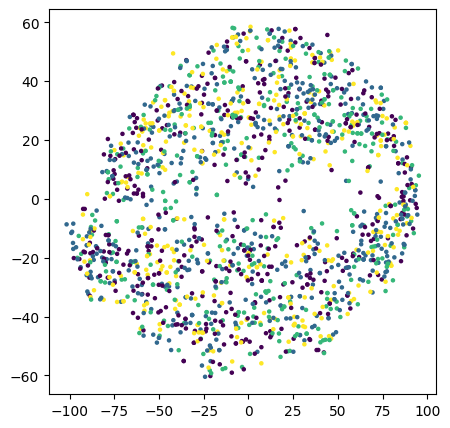

In [ ]:
def _(xyc):
    mask = (xyc[2] > 3).nonzero()
    xyc = xyc.T[mask].T
    fig_name = 'sequence embeding'
    plt.close(fig_name)
    fig = plt.figure(num=fig_name, figsize=(5, 5), dpi=100, 
                        facecolor='white', edgecolor='black')
    ax = fig.add_subplot(111)
    ax.scatter(xyc[0], xyc[1], s=5, c=xyc[2], cmap='viridis', alpha=1)
    plt.show()

_(SEQ_EMB_TSNE)

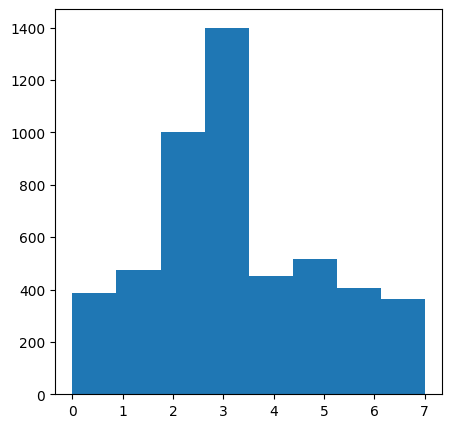

In [ ]:
def _():
    SEQ_EMB['sqc_emb_label'][:10]
    # DATA_OBJECT.vp_tokenizer.token_map 
    xxx = [DATA_OBJECT.vp_tokenizer.token_map[_] \
                        for _ in SEQ_EMB['sqc_emb_label']]
    
    fig_name = 'virtual label distribution'
    plt.close(fig_name)
    fig = plt.figure(num=fig_name, figsize=(5, 5), dpi=100, 
                        facecolor='white', edgecolor='black')
    ax = fig.add_subplot(111)
    ax.hist(xxx, bins=len(DATA_OBJECT.vp_tokenizer.token_map))
    plt.show()

_()

In [ ]:
import seaborn as sns


def _(head=-1, layer=-1, count=100):

    test_dataloader = DataLoader(
        DATA_OBJECT.test_dataset,
        batch_size=count,  # len(DATA_OBJECT.test_dataset),
        shuffle=True,
        pin_memory=False,
        drop_last=True,
    )

    batch = next(iter(test_dataloader))
    input_ids = batch["input"]["input_ids"]
    labels = batch["input"]["labels"]
    mask_token_index = (input_ids == MASK_IDS).nonzero(as_tuple=True)
    input_ids[mask_token_index] = labels[mask_token_index]
    input_ids[:, :12]
    snd_stc_mask = batch["input"]["token_type_ids"].nonzero(as_tuple=True)
    input_ids[snd_stc_mask] = PAD_IDS

    with torch.no_grad():
        model_out = MODEL(
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True,
            **batch["input"],
        )
        # List of attention tensors (one per layer):
        attentions = model_out.attentions
        md(f'''
```
MODEL.config.num_attention_heads: {MODEL.config.num_attention_heads}
len(model_out.attentions): {len(attentions)}
model_out.attentions[0].shape: {attentions[0].shape}
```
Maximal token sequence length is `MODEL.config.max_position_embeddings`.
Attention table shape is (`batch size`, 2, `max_position_embeddings`, `max_position_embeddings`)
The dimension `2` is for `key, query` pairs.
''')
    #

    # Select a specific layer and head for visualization
    # First layer
    # First attention head
    last = 12
    attention = attentions[layer][0, head].numpy()[:last, :last]
    # Shape: (seq_len, seq_len)

    # Tokenize input for labels
    tokens = TOKENIZER.convert_ids_to_tokens(
        batch["input"]["input_ids"][0].squeeze().tolist()
    )[:last]
    # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Plot attention heatmap
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis", cbar=True
    )
    plt.title(f"Attention Weights - Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()


_(head=-1, layer=-1, count=100)

In [ ]:
# def attention_vis():
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

def attention_vis(head=-1, layer=-1, count=100):

    test_dataloader = DataLoader(
                        DATA_OBJECT.test_dataset,
                        batch_size=len(DATA_OBJECT.test_dataset), 
                        shuffle=True, 
                        pin_memory=False,
                        drop_last=True,)



    batch = next(iter(test_dataloader))
      
      with torch.no_grad():
          model_out = MODEL(
                          output_hidden_states=True,
                          output_attentions=True,
                          return_dict=True,
                          **batch['input']
                      )

      attentions = model_out.attentions  # List of attention tensors (one per layer)
      # 

      # Select a specific layer and head for visualization
        # First layer
         # First attention head
      last = 28
      attention = attentions[layer][0, head].numpy()[-last:, -last:]
        # Shape: (seq_len, seq_len)

      # Tokenize input for labels
      tokens = TOKENIZER.convert_ids_to_tokens(batch['input']["input_ids"][0].squeeze().tolist())[-last:]
      # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

      # Plot attention heatmap
      plt.figure(figsize=(7, 5))
      sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, 
                  cmap="viridis", cbar=True)
      plt.title(f"Attention Weights - Layer {layer}, Head {head}")
      plt.xlabel("Key Tokens")
      plt.ylabel("Query Tokens")
      plt.show()

      break